In [1]:
""" Read binary files

The file structure is as follows:
/ Header / Length of DataRecord1 / DataRecord1
         / Length of DataRecord2 / DataRecord2
         / ...
         / Length of DataRecordX / DataRecordX

"""

import struct
import datetime
import numpy as np
import pandas as pd

path_prefix = "~ Documents/"  # data-raw path
path = "data-raw/DS1/"  # training files directory
test_path = "data-raw/DS2/"  # testing files directory

### read DataRecord X (where X must be a positve integer) from file named fileName
### Output is: ['Date_Time', [P1_x - P1_y - P1_z - P2_x - P2_y - P2_z]]
def read_record(fileName, DataRecord):
    ptr = ptr_record(fileName)
    if DataRecord in ptr[:, 0]:
        ptr_pos = ptr[DataRecord-1,1]
        with open(fileName, mode='rb') as file:
            file.seek(ptr_pos)
            signal = read_signal(file)
            file.seek(6*8*4*2, 1) # Skip some unwanted data
            date_time = read_time(file)
            file.close()
        
        return[date_time, signal]
    else:
        print('DataRecord not contained in file')
        return None


### get the ptr. position at the beginning of each DataRecord in the file named fileName
### Output is: [X (DataRecord number) - ptr. position - dim of DataRecord in bytes]
def ptr_record(fileName):
    with open(fileName, mode='rb') as file:
        header = read_header(file)
        nCount = header[0]
        ptr = np.zeros((nCount, 3), 'i')
        i = 0
        while i < nCount:
               ptr[i,0] = i + 1
               length = read_lengthData(file)
               ptr[i,2] = length
               ptr[i,1] = file.tell()
               file.seek(length, 1)
               i = i + 1
    
    file.close()
    return ptr


### read the header -- file is the pointer to the file named fileName
def read_header(file):
    fileContent = file.read(48)
    x = struct.unpack('i'*12, fileContent)
    return x[4], x[6], x[7]


### read the length of the DataRecord -- file is the pointer to the file named fileName
def read_lengthData(file):
    fileContent = file.read(4)
    length = struct.unpack('i', fileContent)
    return length[0]


### read the rescaled signals -- file is the pointer to the file named fileName
def read_signal(file):
    nrow = 75000
    ncol = 6
    signal = np.zeros((nrow, ncol), 'f')
    i = 0
    while i < 6:
        j = 0
        while j < nrow:
            fileContent = file.read(2)
            x = struct.unpack('h', fileContent)
            signal[j,i] = x[0]
            j = j + 1

        fileContent = file.read(6*4)
        y = struct.unpack('f'*6, fileContent)
        scale = ( y[2] / (y[0] - y[1]) ) / y[4]
        signal[:,i] = signal[:,i] * scale

        i = i + 1

    return signal 


### read the time stamp -- file is the pointer to the file named fileName
def read_time(file):
    fileContent = file.read(36)
    info = struct.unpack('iiibbhiHHHHHHHH', fileContent)
    time = datetime.datetime(info[7], info[8], info[10], info[11], info[12], info[13], info[14]*1000)
    return time.isoformat(' ')

In [2]:
"""
Function from binary files to csv.
Given a list of binary files convert them to csv files.
"""
def from_bytes_to_csv_file(path, files, csv_name):
    j = 1
    for file in files:
        frames = []
        ldata = ptr_record(path_prefix + path + file)
        for i in range(1,len(ldata)+1):
            record = read_record(path_prefix + path + file, i)
            time = record[0]
            df = pd.DataFrame(record[1], columns = ['P1_x', 'P1_y', 'P1_z', 'P2_x', 'P2_y', 'P2_z'])
            df['time'] = time
            frames.append(df)
            
        df_records = pd.concat(frames)
        df_records.to_csv(path_prefix + path + csv_name + str(j) + '.csv' , sep='\t',index_label='cycle', encoding='utf-8')
        j+=1

In [3]:
"""
First Dataset - Train and Validation Dataset
from raw-data to separate csv files
"""
OK = ["20130110082835continuo.dat", "20130110082907continuo.dat",
      "20130110083352continuo.dat", "20130110084454continuo.dat"]
IN = ["20130110084754continuo.dat"]
STANDING = ["20130110085127continuo.dat","20130110090319continuo.dat"]

from_bytes_to_csv_file(path, OK, "OK") # OK raw-data conversion
from_bytes_to_csv_file(path, IN, "IN") # IN raw-data conversion
from_bytes_to_csv_file(path, STANDING, "STANDING") # STANDING raw-data conversion

In [4]:
"""
Second Dataset - Test Dataset
from raw-data to separate csv files
"""
test_OK = ["20130111092657continuo.dat"]
test_IN = ["20130111092838continuo.dat"]
test_STANDING = ["20130111093220continuo.dat","20130111094402continuo.dat","20130111095117continuo.dat","20130111095449continuo.dat"]

from_bytes_to_csv_file(test_path, test_OK, "OK") # OK raw-data conversion
from_bytes_to_csv_file(test_path, test_IN, "IN") # IN raw-data conversion
from_bytes_to_csv_file(test_path, test_STANDING, "STANDING") # STANDING raw-data conversion

In [5]:
"""
Load all Train-Validation csv files into one.(df_ok, df_in, df_stand)
"""
OK_csv = ["OK1", "OK2", "OK3", "OK4"]
IN_csv = ["IN1"]
STAND_csv = ["STANDING1", "STANDING2"]

df1 = pd.read_csv(path_prefix + path + OK_csv[0] + ".csv", sep='\t')
df2 = pd.read_csv(path_prefix + path + OK_csv[1] + ".csv", sep='\t')
df3 = pd.read_csv(path_prefix + path + OK_csv[2] + ".csv", sep='\t')
df4 = pd.read_csv(path_prefix + path + OK_csv[3] + ".csv", sep='\t')
""" Load DS1 OK """
df_ok = pd.concat([df1, df2, df3, df4], sort=False)
del df1, df2, df3, df4


In [6]:
""" Load DS1 IN """
df_in = pd.read_csv(path_prefix + path + IN_csv[0] + ".csv", sep='\t')

In [7]:
""" Load DS1 STANDING """
df1 = pd.read_csv(path_prefix + path + STAND_csv[0] + ".csv", sep='\t')
df2 = pd.read_csv(path_prefix + path + STAND_csv[1] + ".csv", sep='\t')
df_stand = pd.concat([df1, df2], sort=False)

del df1, df2

In [8]:
print("--- --- --- --- --- --- --- --- OK Dataset --- --- --- --- --- --- --- ---")
print(df_ok[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())
print("--- --- --- --- --- --- --- --- IN Dataset --- --- --- --- --- --- --- ---")
print(df_in[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())
print("--- --- --- --- --- --- --- --- STANDING Dataset --- --- --- --- --- --- --- ---")
print(df_stand[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())


--- --- --- --- --- --- --- --- OK Dataset --- --- --- --- --- --- --- ---
               P1_x          P2_x          P1_y          P2_y          P1_z  \
count  2.220000e+07  2.220000e+07  2.220000e+07  2.220000e+07  2.220000e+07   
mean  -2.903221e-02  3.220128e-02 -2.151252e-02  1.722817e-02 -9.094217e-03   
std    1.657901e+00  1.284920e+00  2.020221e+00  2.278921e+00  1.100338e+00   
min   -4.380865e+00 -5.502403e+00 -6.810102e+00 -8.204776e+00 -4.058900e+00   
25%   -1.226825e+00 -8.072023e-01 -1.338216e+00 -1.623560e+00 -8.056763e-01   
50%   -1.693751e-01  5.340658e-02 -2.288853e-01 -5.798429e-02  1.525902e-02   
75%    1.313802e+00  8.651865e-01  1.051347e+00  1.533532e+00  8.117800e-01   
max    4.650950e+00  6.144808e+00  9.317159e+00  1.016709e+01  3.537041e+00   

               P2_z  
count  2.220000e+07  
mean   1.713749e-02  
std    1.425474e+00  
min   -5.845731e+00  
25%   -8.987564e-01  
50%   -2.594034e-02  
75%    8.575571e-01  
max    6.410315e+00  
--- --- --- ---

In [9]:
"""
Load all Test csv files into one.(df_ok_test, df_in_test, df_stand_test)
"""
""" Load DS2 """
OK_csv = ["OK1"]
IN_csv = ["IN1"]
STAND_csv = ["STANDING1", "STANDING2", "STANDING3", "STANDING4"]

""" Load DS2 OK """
df_ok_test = pd.read_csv(path_prefix + test_path + OK_csv[0] + ".csv", sep='\t')

In [10]:
""" Load DS2 IN """
df_in_test = pd.read_csv(path_prefix + test_path + IN_csv[0] + ".csv", sep='\t')

In [11]:
df1 = pd.read_csv(path_prefix + test_path + STAND_csv[0] + ".csv", sep='\t')
df2 = pd.read_csv(path_prefix + test_path + STAND_csv[1] + ".csv", sep='\t')
df3 = pd.read_csv(path_prefix + test_path + STAND_csv[2] + ".csv", sep='\t')
df4 = pd.read_csv(path_prefix + test_path + STAND_csv[3] + ".csv", sep='\t')
""" Load DS2 STANDING """
df_stand_test = pd.concat([df1, df2, df3, df4], sort=False)
del df1, df2, df3, df4

In [12]:
print("--- --- --- --- --- --- --- --- OK Test Dataset --- --- --- --- --- --- --- ---")
print(df_ok_test[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())
print("--- --- --- --- --- --- --- --- IN Test Dataset --- --- --- --- --- --- --- ---")
print(df_in_test[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())
print("--- --- --- --- --- --- --- --- STANDING Test Dataset --- --- --- --- --- --- --- ---")
print(df_stand_test[['P1_x','P2_x','P1_y','P2_y','P1_z','P2_z']].describe())

--- --- --- --- --- --- --- --- OK Test Dataset --- --- --- --- --- --- --- ---
               P1_x          P2_x          P1_y          P2_y          P1_z  \
count  2.550000e+06  2.550000e+06  2.550000e+06  2.550000e+06  2.550000e+06   
mean  -2.854664e-02  3.537001e-02 -2.350093e-02  1.931392e-02 -8.225149e-03   
std    1.951706e+00  2.335348e+00  2.740308e+00  3.315413e+00  1.367476e+00   
min   -5.006485e+00 -9.910735e+00 -8.934157e+00 -1.243915e+01 -4.713512e+00   
25%   -1.611353e+00 -1.664759e+00 -1.812772e+00 -2.247654e+00 -9.109636e-01   
50%    7.782101e-02  7.629511e-03 -1.693751e-01 -2.853437e-01  1.541161e-01   
75%    1.423667e+00  1.696803e+00  1.383993e+00  2.166781e+00  9.781033e-01   
max    6.088350e+00  9.460593e+00  1.353475e+01  1.425803e+01  4.623484e+00   

               P2_z  
count  2.550000e+06  
mean   1.649968e-02  
std    1.872406e+00  
min   -7.173266e+00  
25%   -1.176471e+00  
50%    6.713970e-02  
75%    1.141375e+00  
max    7.840085e+00  
--- --- --

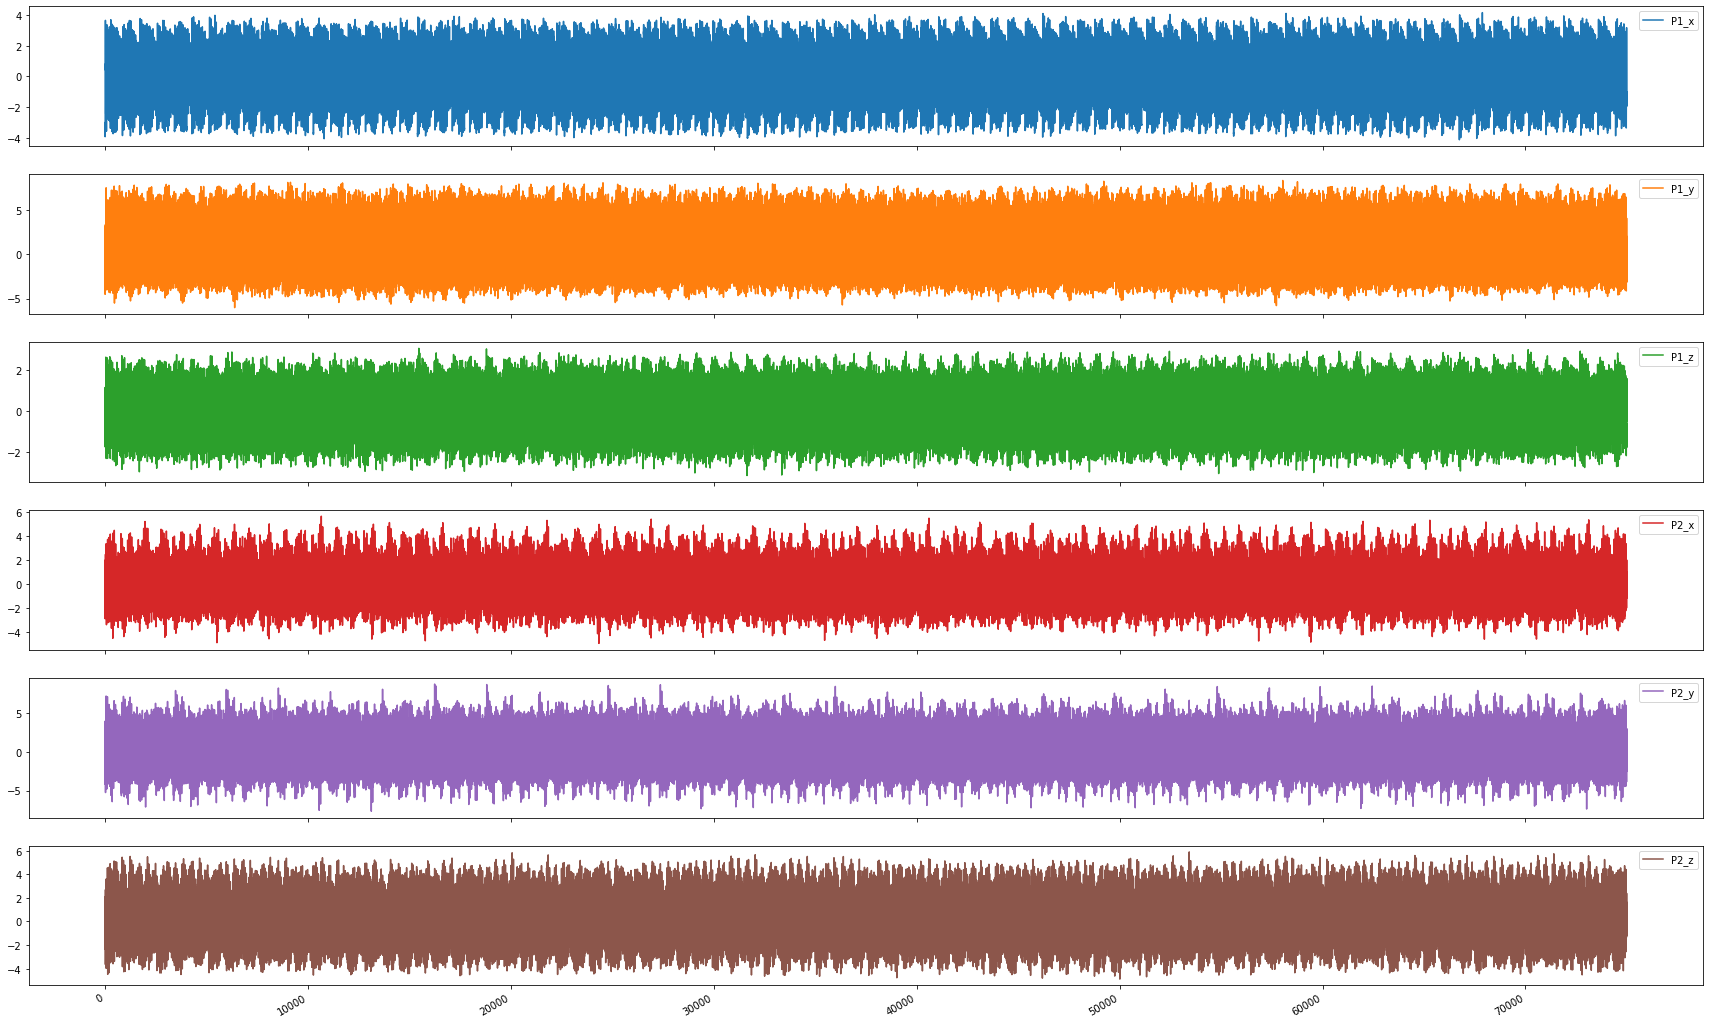

In [13]:
""" first 3 seconds df_ok components plot """
f = 0
t = 75000
cols = ['P1_x', 'P1_y', 'P1_z', 'P2_x', 'P2_y', 'P2_z']
ax = df_ok.iloc[f:t][cols].plot(subplots=True, sharex=True, figsize=(30,20))

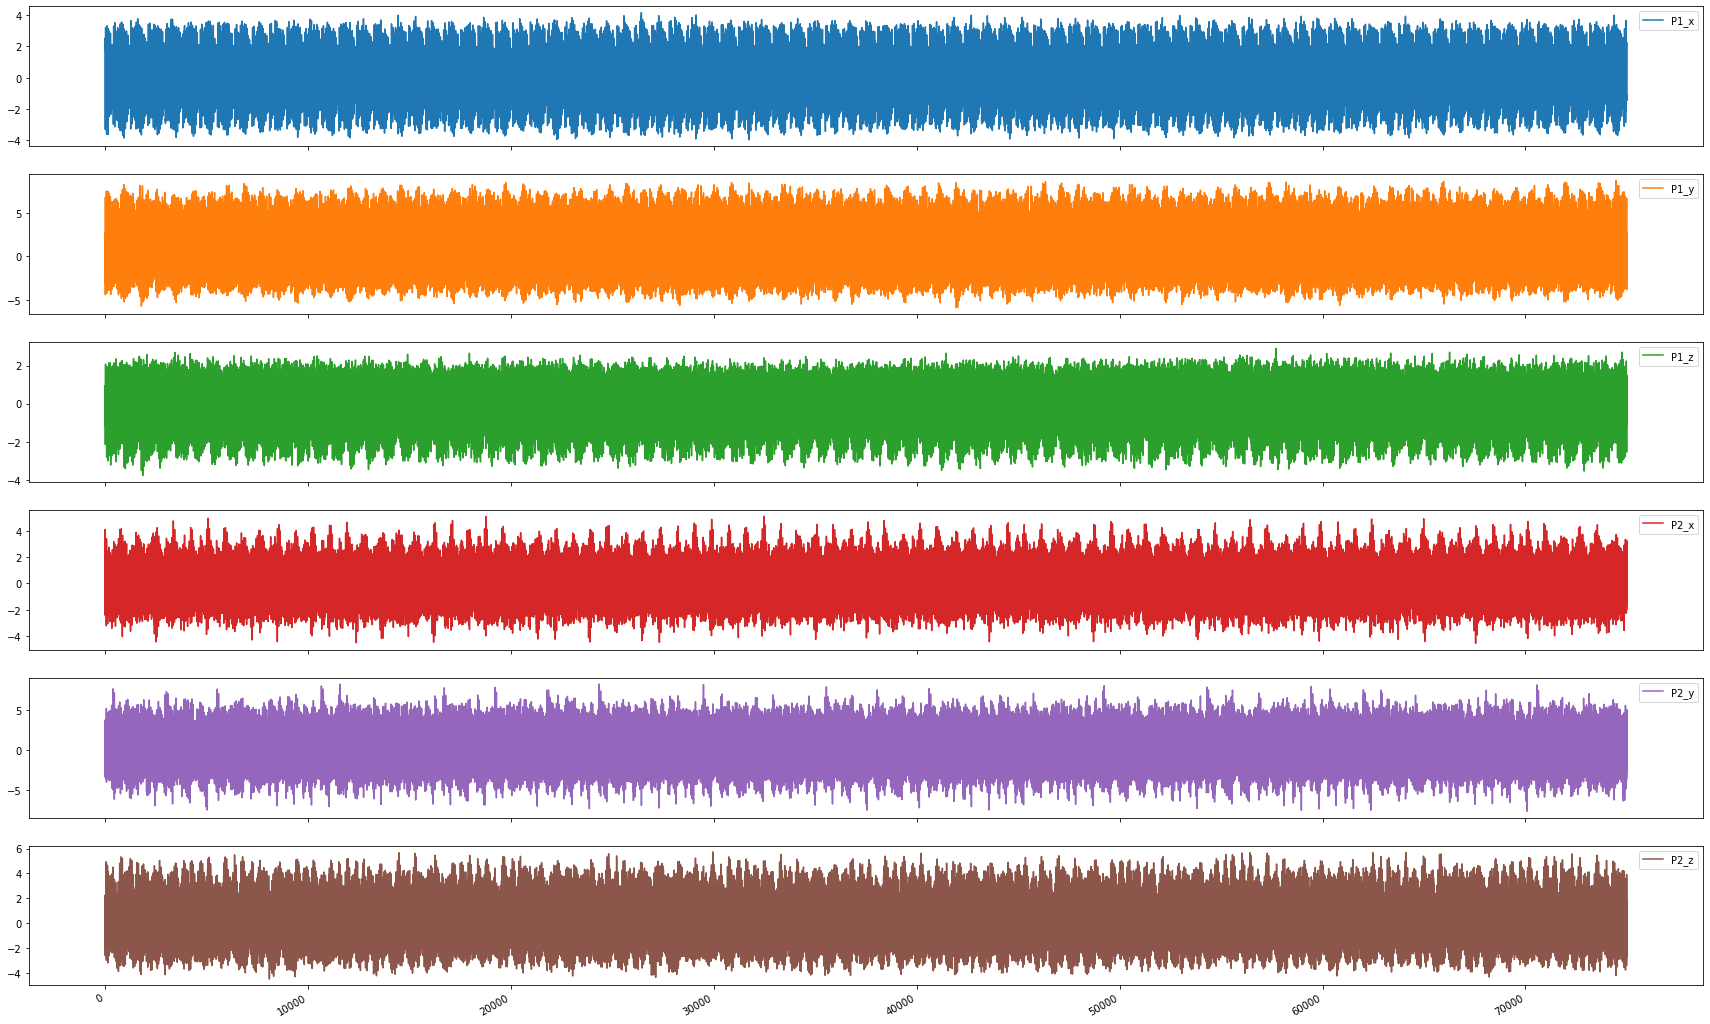

In [14]:
""" first 3 seconds df_in components plot """
ax = df_in.iloc[f:t][cols].plot(subplots=True, sharex=True, figsize=(30,20))

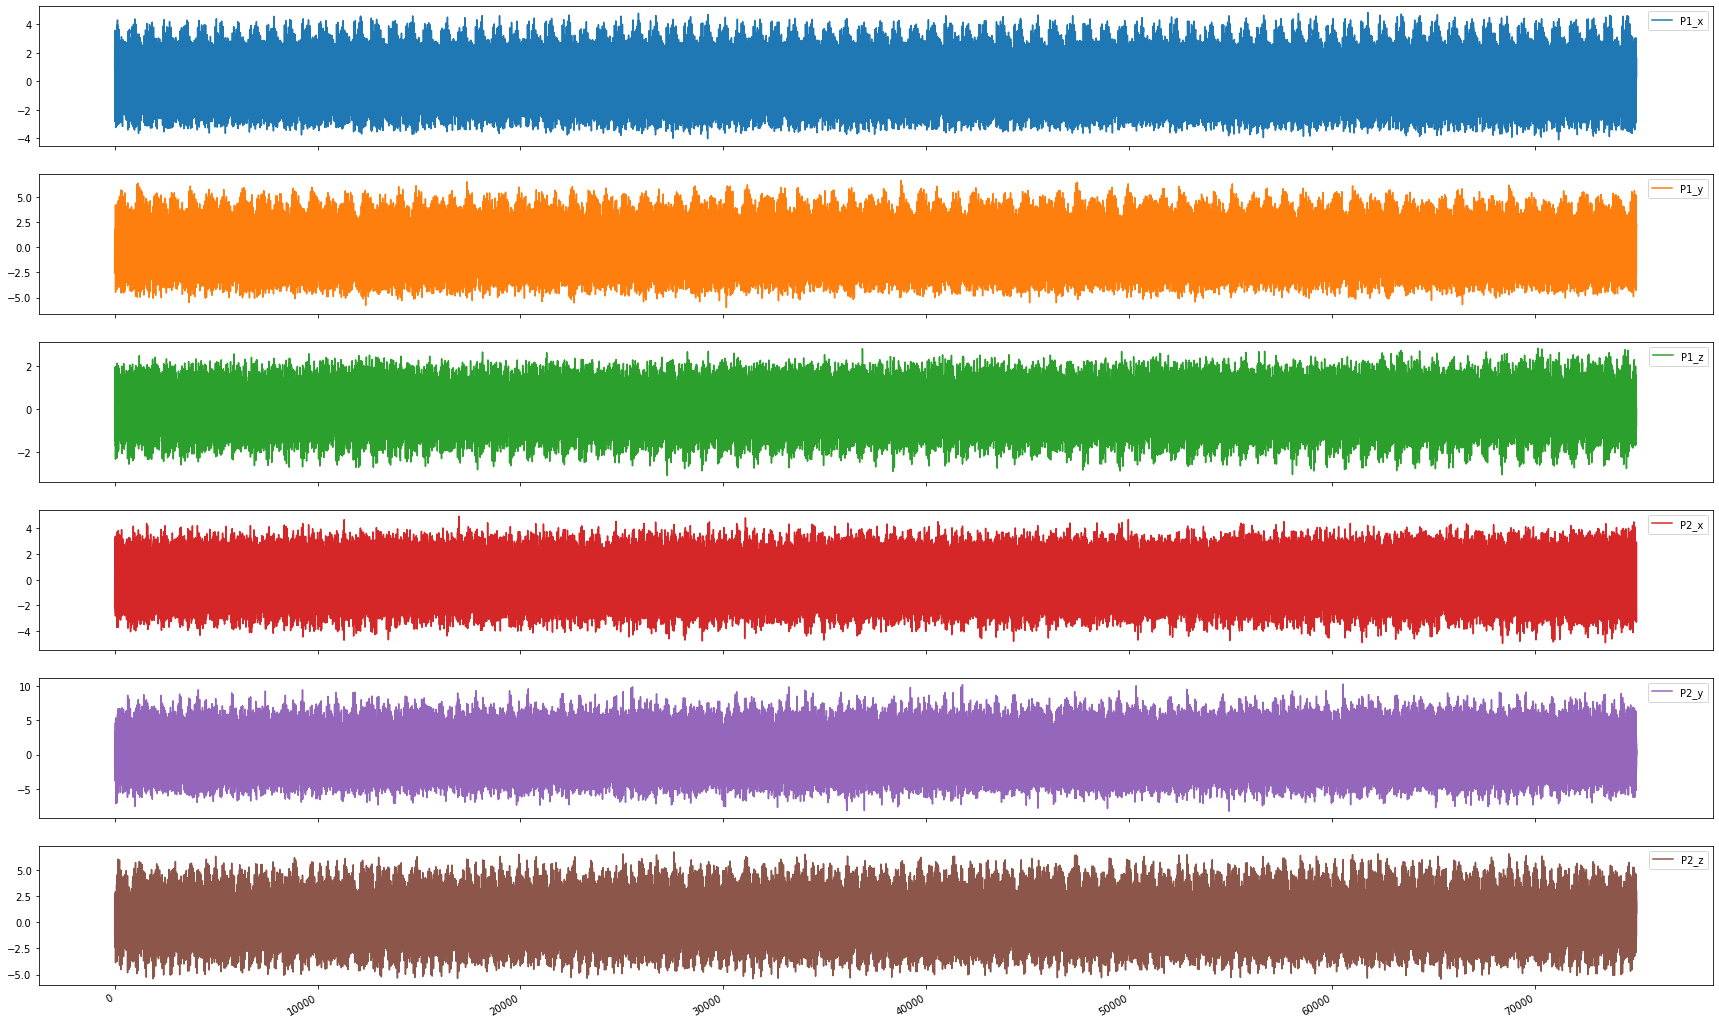

In [15]:
""" first 3 seconds  df_in components plot """
ax = df_stand.iloc[f:t][cols].plot(subplots=True, sharex=True, figsize=(30,20))